### Business Overview

Oxford dictionary describes an echo chamber as, "an environment in which somebody encounters only opinions and beliefs similar to their own, and does not have to consider alternatives." According to this <a href="https://www.pewresearch.org/journalism/2021/01/12/news-use-across-social-media-platforms-in-2020/">Pew Research Center study</a>, 53% of American adults say they get news from social media “often” or “sometimes,”. And, this <a href="https://www.pnas.org/content/118/9/e2023301118">2021 National Academy of Sciences study</a>  on echo chambers on social media platforms found "the aggregation of users in homophilic clusters dominates online interactions on Facebook and Twitter." While social media sites need to take some of the responsibility, I want to take a look at the content being shared and discussed within the echo chambers. It is important to take a look at what information and messaging are being spread with the echo chambers. An article in<a href="https://www.scientificamerican.com/article/why-social-media-makes-us-more-polarized-and-how-to-fix-it/">Scientific American</a>  discusses how social media, specifically social media influencers, have a disproportionate impact on their communities. I am not investigating how these influencers came to be. I am interested in what they are sharing in the space.

The good people at Allsides.com try to help people "easily identify different perspectives so you can get the full picture and think for yourself." Today's media is very biased. And a lot of media sources are very accessible. As shown in the National Academy of Sciences Paper, newsfeeds are often an echo chamber based on the history of related articles and news sites, especially on Facebook. By nature, echo chambers remove media sources outside of someone's chamber, making it difficult to understand different viewpoints regarding news events. Knowing what words and terms determine bias creates transparency about topics in the article. The reader can know certain words and phrases are used in different biased articles and go deeper into the article to think about why the author used the words they did, or what message are they sending by using that word. Helping people become aware of what words and phrases drive bias in news media content can help people understand both sides of an argument.

People who do want to explore both sides of an argument may visit a site like AllSides.com to gauge a news site's bias. All sides uses many methods to rate bias, including third-party data with the requirement of transparency in the system. I have developed a model to determine bias in a corpus of news articles based on the language used in each article. To add transparency and explainability to my model I have utilized LIME to show what words and phrases lead to a better understanding of media bias and more informed readers

### Data Understanding

I would have liked to use one dataset, however, the computational cost was too high which lead me to shrink the size of the dataset. This data was gathered from <a href="https://components.one/datasets/all-the-news-2-news-articles-dataset/">the website</a>  and <a href="https://www.kaggle.com/snapcrack/all-the-news">Kaggle</a> . The Kaggle dataset was created from the source site but different for a different database. The DataFrames contained the same content and allowed me to use information from both to develop the working DataFrame.
I began by looking at the data and understanding I would only be able to predict left, center or right. I did not have enough data to make a 5 class predictor. From there I decided to select two left-focused, two center-focused, and two right-focused media outlets. The news sources were determined by looking at MediaBias/Fact Check and Allsides.com Media Bias lists and selecting sources that each independent side agreed on. After selecting my sources, I began to gather the articles in one DataFrame.

I started to gather information for my Dataframe in the <a href="https://github.com/DaveMcKinley/MediaBiasAnalysis/blob/main/Notebooks/workingDF.ipynb">WorkingDF Notebook</a>.  I decided to go with two sources for each category of bias. The sources do not have an equal number of articles. And each bias is not an equal split. The Kaggle Dataset had all the sources I needed for the right-leaning articles and one source for the center and left biases. I imported each CSV file from Kaggle and selected the sources I needed. I then flipped over to the <a href="https://github.com/DaveMcKinley/MediaBiasAnalysis/blob/main/Notebooks/Split.ipynb">Split Notebook</a>. Due to the size of the dataset, I randomly selected 35 percent of the 2.7 million articles in the components dataset. I then pulled stories from Vox and The Hill. To maintain class balance, I randomly select between 16,000 and 17,000 texts published on The Hill's website. I then pickled the two DatafFrames and imported them into the WorkingDF notebook. I then combined all of the DataFrames into one working DataFrame. I then pickled my working DataFrame and imported it into the EDA/preprocessing notebook. Once I processed the data for modeling I again pickled the processed DataFrame and loaded it into the Modeling notebook. For this notebook, I have pulled the unprocessed Working DataFrame to elaborate on my preprocessing steps. In total, I gathered approximately 85,000 articles from the two datasets. Each row contains an article, publisher, and bias label. For modeling, I will use the article and bias.

This data set could be used to its full potential with better computing power. The article corpus also has a limited amount of right-leaning news sources. Left-leaning sources are abundant. With a greater variety of sources, I would like to expand this classifier.

In [1]:
#import the necessary libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import random
from itertools import islice

import nltk
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk import FreqDist
import re
import string

from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from xgboost import XGBClassifier

from sklearn.model_selection import train_test_split, GridSearchCV, cross_validate, cross_val_score
from sklearn import metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, plot_confusion_matrix
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_curve

from tensorflow import keras
from tensorflow.keras import layers, regularizers
from keras.utils import to_categorical
from keras.layers import Dense, Dropout, Reshape, Flatten, concatenate, Input, Embedding

import lime
from lime import lime_text
from lime.lime_text import LimeTextExplainer
from textblob import TextBlob

In [2]:
def countplot(df, col, hue=None, rotation=None, order=None):
    """
    This function builds a Seaborn countplot and allows the user to set certain parameters to customize the graph.
    
    df - dataframe being used
    col- column in dataframe being used
    hue - second column being used(if any)
    rotation - sets the rotation of the x-ticks for readability
    """
    fig, ax = plt.subplots(figsize=(12,8))
    sns.countplot(data = df, x = col, hue = hue, order = order)
    ax.set_xticklabels(labels = ax.get_xticklabels(), rotation= rotation, fontsize = 15)
    ax.set_xlabel(xlabel = col, fontsize = 20)
    ax.tick_params(axis='y', which='major', labelsize=15)
    ax.set_ylabel(ylabel = "Number of articles", fontsize = 20)
    ax.set_title(f"Number of articles per {col}", fontsize = 30)
    plt.show()
    
    
def preprocess(content):
    """
    This function preprocesses textual data for modeling.
    Steps:
    Lower case each word
    Remove unwanted noise from the article(such as Twitter mentions, web adresses and other content)
    Remove all numbers
    Tokenize the list
    Remove common stop words and punctuation
    Lemmatizes each word
    Returns a string of the remaining lemmatized words.
    
    Content - piece of text to process
    """
    #Turn all the tokens lowercase
    content = content.lower()
    #rmove necessary item from content (see above)
    content1 = re.sub(pattern_mentions, " ", str(content))
    content2 = re.sub(pattern_views, " ", str(content1))
    content3 = re.sub(pattern_thread, " ", str(content2))
    content4 = re.sub(pattern_url, " ", str(content3))
    content5 = re.sub(pattern_num, " ", str(content4))
    content6 = re.sub(pattern_pic, " ", str(content5))
    #Only include words with 3 or more characters
    token_list = tokenizer.tokenize(content6)
    #Remove stopwords
    stopwords_removed=[token for token in token_list if token not in stopwords_list]
    #Lemmatize the remaining word tokens
    lemma_list = [lemma.lemmatize(token) for token in stopwords_removed]
    #Turn the lemma list into a string for the Vectorizer
    cleaned_string = " ".join(lemma_list) 
    return str(cleaned_string)

def evaluate(model, X_tr, y_tr, X_te, y_te):
    print('Accuracy Score:')
    print(f'Train - {accuracy_score(y_tr, model.predict(X_tr))}')
    print(f'Test - {accuracy_score(y_te, model.predict(X_te))}')
    print('  ')
    print('Classification Report:')
    print(classification_report(y_te, model.predict(X_te)))
    print('Confusion matrix for test data')
    return plot_confusion_matrix(model, 
                                 X_te, y_te, 
                                 include_values=True, 
                                 display_labels =  ["Left", "Center", "Right"], 
                                 cmap=plt.cm.Blues)

def create_embedding_matrix(glove_filepath, word_index, embedding_dim):
    '''
    Grabs the embeddings just for the words in our vocabulary
    
    Inputs:
    glove_filepath - string, location of the glove text file to use
    word_index - word_index attribute from the keras tokenizer
    embedding_dim - int, number of dimensions to embed, a hyperparameter
    
    Output:
    embedding_matrix - numpy array of embeddings
    '''
    vocab_size = len(word_index) + 1  # Adding again 1 because of reserved 0 index
    embedding_matrix = np.zeros((vocab_size, embedding_dim))

    with open(glove_filepath, encoding="UTF-8") as f:
        for line in f:
            word, *vector = line.split()
            if word in word_index:
                idx = word_index[word] 
                embedding_matrix[idx] = np.array(
                    vector, dtype=np.float32)[:embedding_dim]

    return embedding_matrix

def visualize_training_results(history):
    '''
    From https://machinelearningmastery.com/display-deep-learning-model-training-history-in-keras/
    
    Input: keras history object (output from trained model)
    '''
    fig, (ax1, ax2) = plt.subplots(2, sharex=True)
    fig.suptitle('Model Results')

    # summarize history for accuracy
    ax1.plot(history.history['accuracy'])
    ax1.plot(history.history['val_accuracy'])
    ax1.set_ylabel('Accuracy')
    ax1.legend(['train', 'test'], loc='upper left')
    # summarize history for loss
    ax2.plot(history.history['loss'])
    ax2.plot(history.history['val_loss'])
    ax2.set_ylabel('Loss')
    ax2.legend(['train', 'test'], loc='upper left')
    
    plt.xlabel('Epoch')
    plt.show()

In [3]:
#take engineered dataframe from pickle 
df = pd.read_pickle("data/df.pkl")
df.head()

Publication                                            Content  Bias
0         CNN  Istanbul (CNN) At least 39 people were killed ...  Left
1         CNN  Atlanta (CNN) This season’s College Football P...  Left
2         CNN   (CNN) Revelers on the United States’ west coa...  Left
3         CNN  West Palm Beach, Florida (CNN)  Donald Trump s...  Left
4         CNN   (CNN) Two small planes collided in Texas on S...  Left

In [11]:
# taking a look at  the legnths of each article
df['word_count'] = df["Content"].apply(lambda x: len(nltk.word_tokenize(str(x))) )
df['char_count'] = df["Content"].apply(lambda x: sum(len(word) for word in nltk.word_tokenize(str(x))) )
df['sentence_count'] = df["Content"].apply(lambda x: len(nltk.sent_tokenize(str(x))))

I limit the articles to at least 50 words and no more than 5000 words. Limiting the corpus cleans out content willed with meaningless content such as random characters or advertisements and larger content that are filled with a stream of breaking news updates rather than written articles. There can be another project in investigating the live tweets of a news story.

In [12]:
df = df[(df["word_count"] < 5000) & (df["word_count"] > 50)]
df

Publication                                            Content  \
0                  CNN  Istanbul (CNN) At least 39 people were killed ...   
1                  CNN  Atlanta (CNN) This season’s College Football P...   
2                  CNN   (CNN) Revelers on the United States’ west coa...   
3                  CNN  West Palm Beach, Florida (CNN)  Donald Trump s...   
4                  CNN   (CNN) Two small planes collided in Texas on S...   
...                ...                                                ...   
85360  National Review  I first read Thomas Sowell in college  —   no ...   
85361  National Review  Whether it’s celebrated according to the Grego...   
85362  National Review  Editor’s Note: This piece first appeared in th...   
85363  National Review  Israel would seem to be in a disastrous positi...   
85364  National Review  The year 2016 was a good one for books by men ...   

        Bias  bias  word_count  char_count  sentence_count  
0       Left     0        1096        4625              43  
1       Left     0        1114        4334              61  
2       Left     0         980        4225              38  
3       Left     0         709        2959              25  
4       Left     0          97         450               5  
...      ...   ...         ...         ...             ...  
85360  Right     2         954        4175              40  
85361  Right     2        1356        6284              30  
85362  Right     2         846        3202              31  
85363  Right     2         905        4014              45  
85364  Right     2        1039        4404              40  

[83524 rows x 7 columns]

In [16]:
#check the shape of the data
df.shape

(83524, 6)

In [17]:
#is anything null?
df.isna().sum()

Publication       0
Content           0
Bias              0
word_count        0
char_count        0
sentence_count    0
dtype: int64

In [18]:
#How many atcles per publication?
df["Publication"].value_counts()

Breitbart          23329
The Hill           16085
Vox                16037
CNN                11242
Reuters            10709
National Review     6122
Name: Publication, dtype: int64

In [19]:
#How many atcles per Bias?
df["Bias"].value_counts()

Right     29451
Left      27279
Center    26794
Name: Bias, dtype: int64

In [20]:
print("Percentage of Articles per Bias in Dataset:")
df["Bias"].value_counts(normalize=True)*100

Percentage of Articles per Bias in Dataset:


Right     35.260524
Left      32.660074
Center    32.079402
Name: Bias, dtype: float64

## Visualize the data

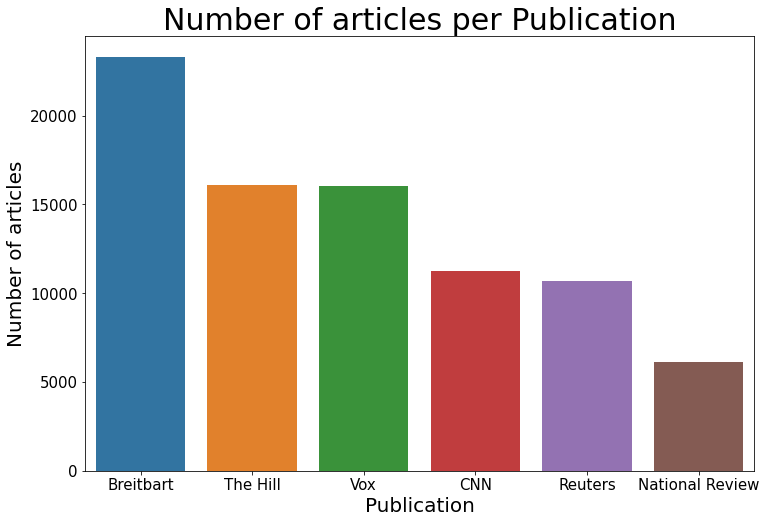

In [21]:
#number of articles per publication
countplot(df, "Publication", order = df["Publication"].value_counts().index)

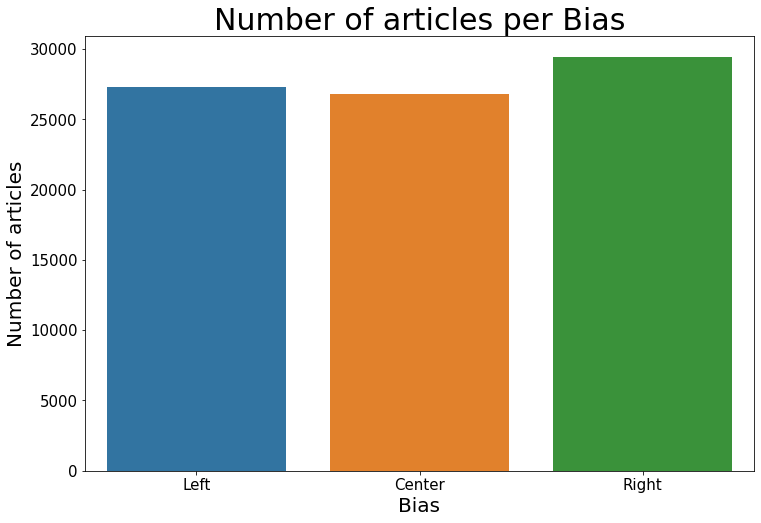

In [22]:
#number of articles per publication
countplot(df, "Bias", order = ["Left", "Center", "Right"])

In [23]:
#group 
df_plot = df.groupby(['Publication', 'Bias']).size().reset_index().pivot(columns='Publication', index='Bias', values=0)

In [24]:
df_plot = df_plot.reindex(["Left", "Center", "Right"])

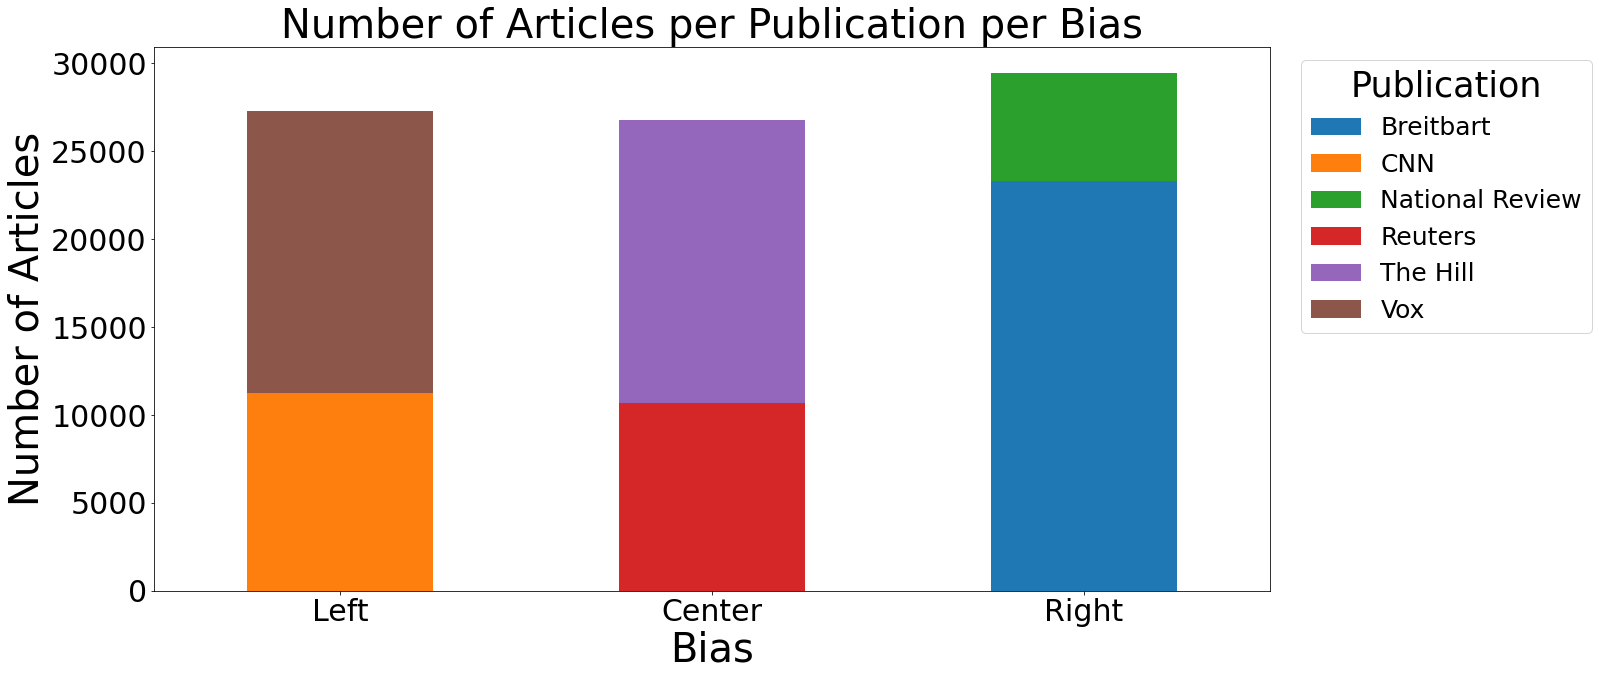

In [25]:
df_plot.plot(kind='bar', stacked=True, figsize=(20,10))
plt.xticks(rotation="horizontal", fontsize = 30)
plt.xlabel(xlabel = "Bias", fontsize = 40)
plt.yticks(rotation="horizontal", fontsize = 30)
plt.ylabel(ylabel = "Number of Articles", fontsize = 40)
plt.title(label= "Number of Articles per Publication per Bias", fontsize = 40)
plt.legend(bbox_to_anchor=(1.3, 1), loc="upper right", ncol=1, fontsize= 25, title = "Publication", title_fontsize= 35)
plt.show()

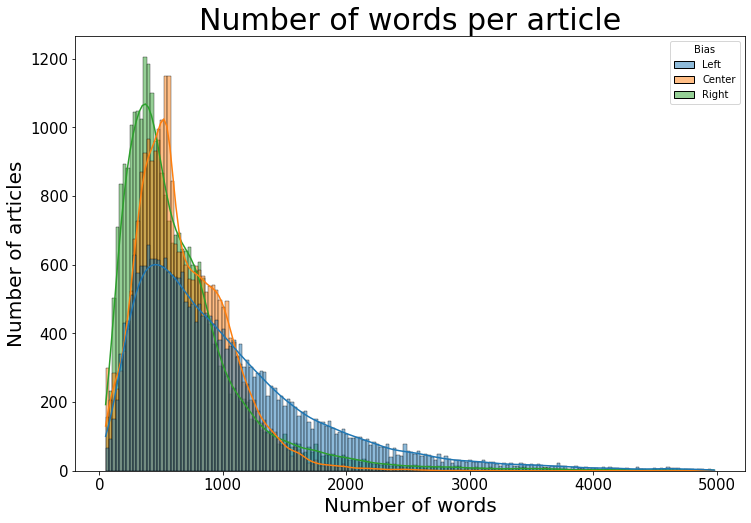

In [26]:
#take a look at the distribution of number of words in each article
fig, ax = plt.subplots(figsize=(12,8))
hp = sns.histplot(data = df, x="word_count", hue = "Bias", kde=True)
ax.set_xlabel(xlabel = "Number of words", fontsize = 20)
ax.tick_params(axis='y', which='major', labelsize=15)
ax.tick_params(axis='x', which='major', labelsize=15)
ax.set_ylabel(ylabel = "Number of articles", fontsize = 20)
ax.set_title(f"Number of words per article", fontsize = 30)
plt.show()

Left biased articles tend to be longer compared to the other two biases. It is not as skewed to the right.

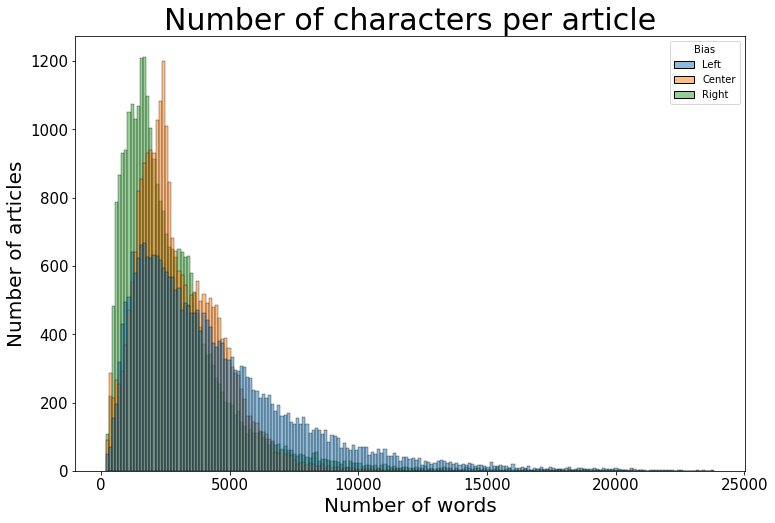

In [27]:
#take a look at the distribution of number of characters in each article
fig, ax = plt.subplots(figsize=(12,8))
sns.histplot(data = df, x="char_count", hue = "Bias")
ax.set_xlabel(xlabel = "Number of characters", fontsize = 20)
ax.tick_params(axis='y', which='major', labelsize=15)
ax.tick_params(axis='x', which='major', labelsize=15)
ax.set_ylabel(ylabel = "Number of articles", fontsize = 20)
ax.set_title(f"Number of characters per article", fontsize = 30)
plt.show()

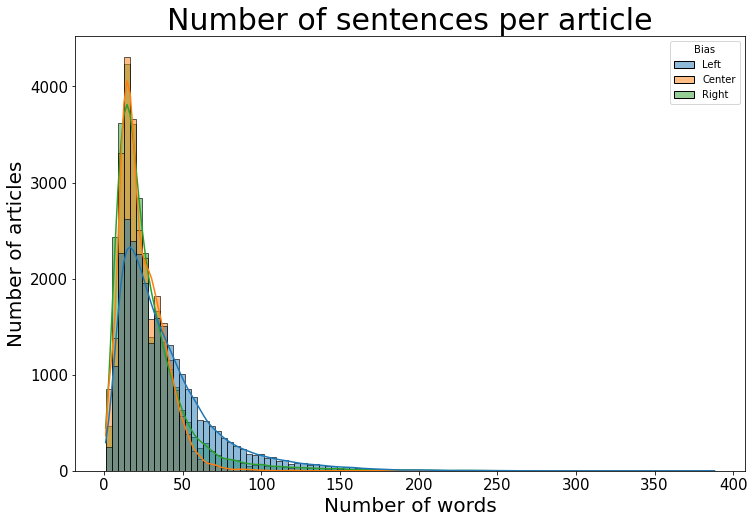

In [28]:
#take a look at the distribution of number of sentences in each article
fig, ax = plt.subplots(figsize=(12,8))
sns.histplot(data = df, x="sentence_count", hue = "Bias", bins = 100, kde = True)
ax.set_xlabel(xlabel = "Number of sentances", fontsize = 20)
ax.tick_params(axis='y', which='major', labelsize=15)
ax.tick_params(axis='x', which='major', labelsize=15)
ax.set_ylabel(ylabel = "Number of articles", fontsize = 20)
ax.set_title(f"Number of sentences per article", fontsize = 30)
plt.show()

While these distributions are right skewed, the data is shaped fairly the same way.

## Data Prep

### Preprocessing Data

I went through a series of operations to preprocess the data for Machine Learning. The first step was to encode the bias with a -1 for left, 0 for the center, and 1 for right.
<br>

In the preprocessing step of the project I followed these steps:

- Lower case each word
- Remove unwanted noise from the article(such as Twitter mentions, web addresses, and other content)
- Remove all numbers
- Tokenize the list
- Remove common stop words and punctuation
- Lemmatizes each word
- Returns a string of the remaining lemmatized words

First I lowercase all the words to simplify the cleaning process. I then remove noise like mentions(@abc1123), hashtags(#), and URLs because they do not add anything to the analysis. I also remove information at the end of The Hill's articles because it is contact information and does not help with analysis. Numbers are removed because they have no context by themselves. We tokenize the list and remove any common stopwords and punctuation. Tokenizing a list is breaking each element in the list into its own list object. Next, I lemmatized the remaining words and combines the tokens back into a string to be vectorized.

In [29]:
#check the data set
df

Publication                                            Content  \
0                  CNN  Istanbul (CNN) At least 39 people were killed ...   
1                  CNN  Atlanta (CNN) This season’s College Football P...   
2                  CNN   (CNN) Revelers on the United States’ west coa...   
3                  CNN  West Palm Beach, Florida (CNN)  Donald Trump s...   
4                  CNN   (CNN) Two small planes collided in Texas on S...   
...                ...                                                ...   
85360  National Review  I first read Thomas Sowell in college  —   no ...   
85361  National Review  Whether it’s celebrated according to the Grego...   
85362  National Review  Editor’s Note: This piece first appeared in th...   
85363  National Review  Israel would seem to be in a disastrous positi...   
85364  National Review  The year 2016 was a good one for books by men ...   

        Bias  word_count  char_count  sentence_count  
0       Left        1096        4625              43  
1       Left        1114        4334              61  
2       Left         980        4225              38  
3       Left         709        2959              25  
4       Left          97         450               5  
...      ...         ...         ...             ...  
85360  Right         954        4175              40  
85361  Right        1356        6284              30  
85362  Right         846        3202              31  
85363  Right         905        4014              45  
85364  Right        1039        4404              40  

[83524 rows x 6 columns]

In [4]:
# Multiclass the bias column
dict_sent = {'Left':0, 
             'Center':1,
             'Right':2}
df["bias"] = df["Bias"].map(dict_sent)

Check all three labels

In [49]:
df.head()

Publication                                            Content  Bias  \
0         CNN  Istanbul (CNN) At least 39 people were killed ...  Left   
1         CNN  Atlanta (CNN) This season’s College Football P...  Left   
2         CNN   (CNN) Revelers on the United States’ west coa...  Left   
3         CNN  West Palm Beach, Florida (CNN)  Donald Trump s...  Left   
4         CNN   (CNN) Two small planes collided in Texas on S...  Left   

   word_count  char_count  sentence_count  bias  
0        1096        4625              43     0  
1        1114        4334              61     0  
2         980        4225              38     0  
3         709        2959              25     0  
4          97         450               5     0

In [32]:
df.iloc[45000:45005]

Publication                                            Content    Bias  \
45862    The Hill  China's commerce minister on Saturday warned t...  Center   
45863    The Hill  President TrumpDonald John TrumpO'Rourke: Trum...  Center   
45865    The Hill  With President Trump yet to fill top positions...  Center   
45866    The Hill  When I started LGBTrump — the largest Gays for...  Center   
45867    The Hill  A hacker group called “OurMine” breached Netfl...  Center   

       word_count  char_count  sentence_count  bias  
45862         241        1037               9     1  
45863         274        1311               8     1  
45865        1312        5370              44     1  
45866        1312        5701              46     1  
45867         189         833               9     1

In [33]:
df.tail()

Publication                                            Content  \
85360  National Review  I first read Thomas Sowell in college  —   no ...   
85361  National Review  Whether it’s celebrated according to the Grego...   
85362  National Review  Editor’s Note: This piece first appeared in th...   
85363  National Review  Israel would seem to be in a disastrous positi...   
85364  National Review  The year 2016 was a good one for books by men ...   

        Bias  word_count  char_count  sentence_count  bias  
85360  Right         954        4175              40     2  
85361  Right        1356        6284              30     2  
85362  Right         846        3202              31     2  
85363  Right         905        4014              45     2  
85364  Right        1039        4404              40     2

In [5]:
#initialize the Tokenizer and Lemmatizer
tokenizer = RegexpTokenizer(r"(?u)\b\w\w+\b")
lemma = WordNetLemmatizer()

In [6]:
# Create a list of new sources to add to stopwords list
source = list(df["Publication"].unique())
source = (map(lambda x: x.lower(), source))
source = list(source)
source

['cnn', 'vox', 'reuters', 'the hill', 'breitbart', 'national review']

In [7]:
#create stopwords_list, adds punctuation and the news sources to list
stopwords_list = stopwords.words("english")
stopwords_list += string.punctuation
stopwords_list += source
print(stopwords_list)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [8]:
#Regex expressions to remove unwanted noise
pattern_mentions = "((@[a-zA-Z0-9_-]+)((?=\s+)|$|[!?.,-]))"
pattern_views =  "((the views expressed by)([\s\S]*)$)"
pattern_thread = "((view the discussion thread.)([\s\S]*)$)"
pattern_url = "(http\S+)"
pattern_num = "([\d.])"
pattern_pic = "((pic.)?twitter\.com\/[A-Za-z0-9_]{5,1000}(\?(\w+=\w+&?)*)?)"

In [33]:
#random article in the corpus will use to check the preprocessing step
test = df["Content"].iloc[random.randint(0,df.shape[0])]
test

'Google announced on Wednesday a new $50 million initiative to study and prepare “for the changing nature of work,” beginning with investments in the U.S. and Europe to help train job seekers and improve the working conditions for those already employed. The commitment comes by way of Google.org, the search giant’s philanthropic organization. Its president, Jacquelline Fuller, unveiled the campaign in a blog post this morning, stressing the goal is to “make sure that as many people as possible can make the most of the new jobs, industries and opportunities that are emerging — some of which we couldn’t have imagined just a few years ago.” In other words, Google.org is studying the economic effects precipitated in no small part by its own parent company, Alphabet. To start, some of the new money is heading to groups like Code for America, as Google.org looks to “support organizations who are driving innovative approaches to connecting job seekers and employers,” as Fuller described it. T

In [34]:
#lowercase text
test = test.lower()
test

'google announced on wednesday a new $50 million initiative to study and prepare “for the changing nature of work,” beginning with investments in the u.s. and europe to help train job seekers and improve the working conditions for those already employed. the commitment comes by way of google.org, the search giant’s philanthropic organization. its president, jacquelline fuller, unveiled the campaign in a blog post this morning, stressing the goal is to “make sure that as many people as possible can make the most of the new jobs, industries and opportunities that are emerging — some of which we couldn’t have imagined just a few years ago.” in other words, google.org is studying the economic effects precipitated in no small part by its own parent company, alphabet. to start, some of the new money is heading to groups like code for america, as google.org looks to “support organizations who are driving innovative approaches to connecting job seekers and employers,” as fuller described it. t

In [35]:
# Removes Twitter mentions
test = re.sub(pattern_mentions,"", test)
test

'google announced on wednesday a new $50 million initiative to study and prepare “for the changing nature of work,” beginning with investments in the u.s. and europe to help train job seekers and improve the working conditions for those already employed. the commitment comes by way of google.org, the search giant’s philanthropic organization. its president, jacquelline fuller, unveiled the campaign in a blog post this morning, stressing the goal is to “make sure that as many people as possible can make the most of the new jobs, industries and opportunities that are emerging — some of which we couldn’t have imagined just a few years ago.” in other words, google.org is studying the economic effects precipitated in no small part by its own parent company, alphabet. to start, some of the new money is heading to groups like code for america, as google.org looks to “support organizations who are driving innovative approaches to connecting job seekers and employers,” as fuller described it. t

The Hill articles end with "the views expressed by" or "view the discussion thread" both are followed by some contact information. I decided to remove these elements to prevent missweighing words later in the Vectorizing stage of the project.

In [36]:
# remove the end of The Hill articles starting at the phrase "the views expressed by"
test =  re.sub(pattern_views,"", test)
test

'google announced on wednesday a new $50 million initiative to study and prepare “for the changing nature of work,” beginning with investments in the u.s. and europe to help train job seekers and improve the working conditions for those already employed. the commitment comes by way of google.org, the search giant’s philanthropic organization. its president, jacquelline fuller, unveiled the campaign in a blog post this morning, stressing the goal is to “make sure that as many people as possible can make the most of the new jobs, industries and opportunities that are emerging — some of which we couldn’t have imagined just a few years ago.” in other words, google.org is studying the economic effects precipitated in no small part by its own parent company, alphabet. to start, some of the new money is heading to groups like code for america, as google.org looks to “support organizations who are driving innovative approaches to connecting job seekers and employers,” as fuller described it. t

In [37]:
# remove the end of The Hill articles starting at the phrase "view the discussion thread"
test =  re.sub(pattern_thread,"", test)
test

'google announced on wednesday a new $50 million initiative to study and prepare “for the changing nature of work,” beginning with investments in the u.s. and europe to help train job seekers and improve the working conditions for those already employed. the commitment comes by way of google.org, the search giant’s philanthropic organization. its president, jacquelline fuller, unveiled the campaign in a blog post this morning, stressing the goal is to “make sure that as many people as possible can make the most of the new jobs, industries and opportunities that are emerging — some of which we couldn’t have imagined just a few years ago.” in other words, google.org is studying the economic effects precipitated in no small part by its own parent company, alphabet. to start, some of the new money is heading to groups like code for america, as google.org looks to “support organizations who are driving innovative approaches to connecting job seekers and employers,” as fuller described it. t

In [38]:
#removes hyperlinks starting with http
test =  re.sub(pattern_url,"", test)
test

'google announced on wednesday a new $50 million initiative to study and prepare “for the changing nature of work,” beginning with investments in the u.s. and europe to help train job seekers and improve the working conditions for those already employed. the commitment comes by way of google.org, the search giant’s philanthropic organization. its president, jacquelline fuller, unveiled the campaign in a blog post this morning, stressing the goal is to “make sure that as many people as possible can make the most of the new jobs, industries and opportunities that are emerging — some of which we couldn’t have imagined just a few years ago.” in other words, google.org is studying the economic effects precipitated in no small part by its own parent company, alphabet. to start, some of the new money is heading to groups like code for america, as google.org looks to “support organizations who are driving innovative approaches to connecting job seekers and employers,” as fuller described it. t

In [39]:
#removes numbers from the text.
test =  re.sub(pattern_num,"", test)
test

'google announced on wednesday a new $ million initiative to study and prepare “for the changing nature of work,” beginning with investments in the us and europe to help train job seekers and improve the working conditions for those already employed the commitment comes by way of googleorg, the search giant’s philanthropic organization its president, jacquelline fuller, unveiled the campaign in a blog post this morning, stressing the goal is to “make sure that as many people as possible can make the most of the new jobs, industries and opportunities that are emerging — some of which we couldn’t have imagined just a few years ago” in other words, googleorg is studying the economic effects precipitated in no small part by its own parent company, alphabet to start, some of the new money is heading to groups like code for america, as googleorg looks to “support organizations who are driving innovative approaches to connecting job seekers and employers,” as fuller described it the search gi

In [40]:
#removes pic.twitter urls
test =  re.sub(pattern_pic,"", test)
test

'google announced on wednesday a new $ million initiative to study and prepare “for the changing nature of work,” beginning with investments in the us and europe to help train job seekers and improve the working conditions for those already employed the commitment comes by way of googleorg, the search giant’s philanthropic organization its president, jacquelline fuller, unveiled the campaign in a blog post this morning, stressing the goal is to “make sure that as many people as possible can make the most of the new jobs, industries and opportunities that are emerging — some of which we couldn’t have imagined just a few years ago” in other words, googleorg is studying the economic effects precipitated in no small part by its own parent company, alphabet to start, some of the new money is heading to groups like code for america, as googleorg looks to “support organizations who are driving innovative approaches to connecting job seekers and employers,” as fuller described it the search gi

In [41]:
#tokenize text
test = tokenizer.tokenize(test)
test[:20]

['google',
 'announced',
 'on',
 'wednesday',
 'new',
 'million',
 'initiative',
 'to',
 'study',
 'and',
 'prepare',
 'for',
 'the',
 'changing',
 'nature',
 'of',
 'work',
 'beginning',
 'with',
 'investments']

In [42]:
#remove stopwords
stopwords_removed=[token for token in test if token not in stopwords_list]
stopwords_removed[:20]

['google',
 'announced',
 'wednesday',
 'new',
 'million',
 'initiative',
 'study',
 'prepare',
 'changing',
 'nature',
 'work',
 'beginning',
 'investments',
 'us',
 'europe',
 'help',
 'train',
 'job',
 'seekers',
 'improve']

In [43]:
#lemmatize the remaing words
lemma_list = [lemma.lemmatize(token) for token in stopwords_removed]
lemma_list[:20]

['google',
 'announced',
 'wednesday',
 'new',
 'million',
 'initiative',
 'study',
 'prepare',
 'changing',
 'nature',
 'work',
 'beginning',
 'investment',
 'u',
 'europe',
 'help',
 'train',
 'job',
 'seeker',
 'improve']

In [44]:
#sanity check
test = df["Content"].iloc[random.randint(0,df.shape[0])]
test

' A promised showdown between the chief executives of German luxury car maker Daimler ( ) and   firm Uber, Silicon Valley’s most valuable private company, turned into more of a wary courtship when the two met publicly on Wednesday. Daimler Chief Executive Dieter Zetsche and Uber Chief Executive Travis Kalanick were interviewed together on stage at Axel Springer NOAH, a   conference in Berlin of venture capitalists and technology companies. Both ruled out the prospect of one taking over the other and denied a German magazine report in March that Uber was considering ordering up to 100, 000 cars from the automaker. They sought common ground in many of their comments, while taking   jabs at one another as inevitable competitors.  ”Cars are not going away soon and companies like Uber are not going to be making them,” Uber’s Kalanick said. Zetsche said he had met Kalanick several times and described him as a ”frenemy” which he defined as a combination of friend and enemy, before joking ”We 

In [47]:
preprocess(test)

'promised showdown chief executive german luxury car maker daimler firm uber silicon valley valuable private company turned wary courtship two met publicly wednesday daimler chief executive dieter zetsche uber chief executive travis kalanick interviewed together stage axel springer noah conference berlin venture capitalist technology company ruled prospect one taking denied german magazine report march uber considering ordering car automaker sought common ground many comment taking jab one another inevitable competitor car going away soon company like uber going making uber kalanick said zetsche said met kalanick several time described frenemy defined combination friend enemy joking call marriage german turning serious daimler executive said competitor course might many area competitor future added also friend rise widely seen threat individual car ownership many potential driver reducing demand new car automaker daimler responded investing variety new connected car business potentiall

### Vectorizing data

Once there is a string of processed data. I use a Term Frequency-Inverse Document Frequency (TFIDF) vectorizer to vectorize the documents. The TF-IDF Vectorizer weight is found by measuring the Term Frequency and Inverse Document Frequency. Term frequency is how many times a term appears in the document divided by the number of terms in a document. The Inverse Document Frequency is the log loss of the total number of documents divided by the number of documents with the term in it. It is based on the idea that rare words contain more information about the content of a document than words that are used many times throughout all the documents. Now our corpus of articles is ready for modeling.

In [58]:
#initialize, fit and transform the data
#preprocessor is going to use the processing function to clean the data
#will look at the top 2000 uni- and bigrams
#max_df is set to half of the corpus. any document that apears in half the docs is removed.
#mind_df is set to 10. a word must appear atleast 10 times to be counted
#These paramters will be used throughout modeling
tfidf_vectorizer = TfidfVectorizer(preprocessor=preprocess, max_features= 2000, 
                            ngram_range= (1,2),
                            max_df = .5, min_df = 10)

tfidf_vectorizer.fit(df["Content"])
tfidf_vec = tfidf_vectorizer.transform(df["Content"])
#returna a dataframe using the count vectorizer to label to the columns rather than usless numbers.
tfidf_vec_df = pd.DataFrame(tfidf_vec.toarray())

In [59]:
#What the dataframe will look like for modeling
tfidf_vec_df.head()

0     1     2     3     4     5     6     7         8         9     ...  \
0  0.00000   0.0   0.0   0.0   0.0   0.0   0.0   0.0  0.018344  0.000000  ...   
1  0.00000   0.0   0.0   0.0   0.0   0.0   0.0   0.0  0.000000  0.000000  ...   
2  0.00000   0.0   0.0   0.0   0.0   0.0   0.0   0.0  0.028920  0.000000  ...   
3  0.06528   0.0   0.0   0.0   0.0   0.0   0.0   0.0  0.000000  0.000000  ...   
4  0.00000   0.0   0.0   0.0   0.0   0.0   0.0   0.0  0.000000  0.156859  ...   

   1990  1991  1992      1993      1994  1995      1996  1997  1998  1999  
0   0.0   0.0   0.0  0.047085  0.000000   0.0  0.000000   0.0   0.0   0.0  
1   0.0   0.0   0.0  0.000000  0.000000   0.0  0.000000   0.0   0.0   0.0  
2   0.0   0.0   0.0  0.000000  0.105864   0.0  0.049523   0.0   0.0   0.0  
3   0.0   0.0   0.0  0.000000  0.036883   0.0  0.000000   0.0   0.0   0.0  
4   0.0   0.0   0.0  0.000000  0.000000   0.0  0.000000   0.0   0.0   0.0  

[5 rows x 2000 columns]

## Modeling

For this project, I explored many different models. To keep things short in this notebook I have showcased a baseline, simple and 3 models followed by my final model and evaluation. You can find the rest of the models along with tuning in the Modeling Notebook in the Notebooks folder.

In [12]:
df.head()

Publication                                            Content  Bias
0         CNN  Istanbul (CNN) At least 39 people were killed ...  Left
1         CNN  Atlanta (CNN) This season’s College Football P...  Left
2         CNN   (CNN) Revelers on the United States’ west coa...  Left
3         CNN  West Palm Beach, Florida (CNN)  Donald Trump s...  Left
4         CNN   (CNN) Two small planes collided in Texas on S...  Left

In [13]:
# Content of each article
X = df[["Content"]]
# Target of biases
y= df["bias"]
#set random seed
seed = 42
#holdout set
X_hold, X_test, y_hold, y_test = train_test_split(X, y, test_size=0.10, random_state=seed)
#training set
X_train, X_val, y_train, y_val = train_test_split(X_hold, y_hold, test_size=0.25, random_state=seed)

### Baseline Model

In [14]:
#If we were to randomly guess bias 
y_train.value_counts(normalize= True)

2    0.353116
0    0.327663
1    0.319220
Name: bias, dtype: float64

### Simple Model

In [40]:
#set up pipeline
lr = Pipeline(steps=[
    ('vect', TfidfVectorizer(preprocessor=preprocess, max_features= 2000, 
                            ngram_range= (1,2))),
    ('clf', LogisticRegression(multi_class="multinomial", random_state=seed))
                                                    ])
#fit to training data
lr.fit(X_train["Content"], y_train)

print(lr.score(X_train["Content"], y_train))
print(lr.score(X_val["Content"], y_val))

C:\Users\david\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.8900812373620915
0.8701644229234289


### Tuned Models

To save on computational costs in this notebook, I have only included the best-performing parameters. All of the parameters explored are in the modeling notebook. I used 3 cross-validation folds due to the size and cost of running for folds.

#### Logistic Regression

In the grid search, I added Ridge regression to adjust the weights of the coefficients. I increased the max iterations. I looked at the regularization strength to see how much regression to effect. the solver hyperparameter was limited to 'newton-cg', 'sag', 'saga' and 'lbfgs' for multiclass problems

Accuracy Score:
Train - 0.8893362659193302
Test - 0.8674506465173203
  
Classification Report:
              precision    recall  f1-score   support

          -1       0.84      0.85      0.85      6176
           0       0.92      0.89      0.90      6075
           1       0.85      0.86      0.86      6542

    accuracy                           0.87     18793
   macro avg       0.87      0.87      0.87     18793
weighted avg       0.87      0.87      0.87     18793

Confusion matrix for test data


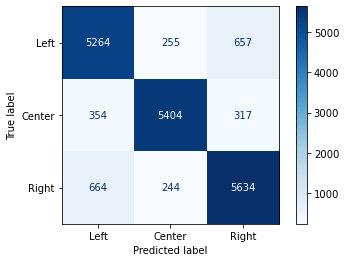

In [65]:
best_lr = Pipeline(steps=[
    ('vect', TfidfVectorizer(preprocessor=preprocess, max_features= 2000, 
                            ngram_range= (1,2),
                            max_df = .5, min_df = 10)),
    ('clf', LogisticRegression(C=1, max_iter=1000,
                                    solver='newton-cg', multi_class="multinomial", random_state=seed)),
])
best_lr.fit(X_train["Content"], y_train)
evaluate(best_lr, X_train["Content"], y_train, X_val["Content"], y_val)

### LIME
It is important to develop an accurate model. But just as important is the explainability of the model. As more complex models are used for analysis, the level of interpretability decreases. It is difficult to explain how certain models, like a neural network, work under the hood. Opening the black box of accurate complex models is an important aspect of this project. While I do want to accurately predict bias, I also want to understand what is driving decision-making and be able to showcase what words are driving decisions.LIME will only define a local point it does not make a global level analysis. By seeing specific examples people can look at the output and determine if the model is making smake choices.


### TextBlob
TextBlob is another NLP package. It is built on Stanford's NLTK module. I use TextBlob's Polarity and Subjectivity score to give the reader more insight into the article. Polarity is on a 1 to -1 scale where 1 means positive statement and -1 means a negative statement. Subjectivity is rated on a 0 to 1 scale where 0 means highly objective and 1 means highly subjective.

In [90]:
#This code was found at https://marcotcr.github.io/lime/tutorials/Lime%20-%20multiclass.html
examples = 12323
idx = example
class_names=["Left", "Center", "Right"]
explainer = LimeTextExplainer(class_names=class_names)
exp = explainer.explain_instance(str(X_val["Content"][idx]), best_lr.predict_proba, num_features=5, labels=[0,1,2])
print(f'Document id: {idx}')
print(f'Predicted bias : {class_names[best_lr.predict(list(X_val["Content"][idx])).reshape(1,-1)[0,0]]}')
print(f'True bias: {class_names[y_val[idx]]}')
print(f'Subjectivity Score: {TextBlob(X_val["Content"][idx]).subjectivity}')
print(f'Polarity Score: {TextBlob(X_val["Content"][idx]).polarity}')
exp.show_in_notebook(text=X_val["Content"][idx], labels=(0, 1, 2))

Document id: 12323
Predicted bias : Center
True bias: Left
Subjectivity Score: 0.5225198666747962
Polarity Score: 0.022757860293071547


The Logistic Regression Model's Accuracy on the validation data was 86.7%. The model had a more difficult time deciding to determine left vs right bias more than right or left vs centered bias. Looking at the LIME explainer the model sees "Canada", "brand", and "company" influencing the model.

### Decision Tree

For the decision tree, I decided to explore the depth of the tree, how many samples are in each leaf, and how many samples to split at an internal node. I adjusted these features because the previous model was very overfitting.

Accuracy Score:
Train - 0.8488772216112668
Test - 0.7699675411057308
  
Classification Report:
              precision    recall  f1-score   support

           0       0.70      0.76      0.73      6176
           1       0.91      0.82      0.86      6075
           2       0.73      0.73      0.73      6542

    accuracy                           0.77     18793
   macro avg       0.78      0.77      0.77     18793
weighted avg       0.78      0.77      0.77     18793

Confusion matrix for test data


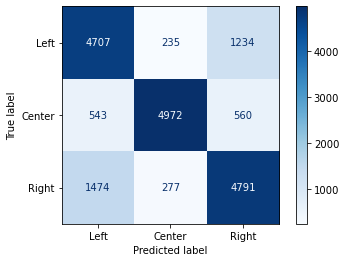

In [92]:
best_dt = Pipeline(steps=[
    ('vect', TfidfVectorizer(preprocessor=preprocess, max_features= 2000, 
                            ngram_range= (1,2))),
    ('clf', DecisionTreeClassifier(max_depth = 25, min_samples_leaf= 10, min_samples_split=5, random_state=seed)),
])
best_dt.fit(X_train["Content"], y_train)
evaluate(best_dt, X_train["Content"], y_train, X_val["Content"], y_val)

In [93]:
idx = example
class_names=["Left", "Center", "Right"]
explainer = LimeTextExplainer(class_names=class_names)
exp = explainer.explain_instance(str(X_val["Content"][idx]), best_dt.predict_proba, num_features=5, labels=[0, 1, 2])
print(f'Document id: {idx}')
print(f'Predicted bias : {class_names[best_dt.predict(list(X_val["Content"][idx])).reshape(1,-1)[0,0]]}')
print(f'True Bias: {class_names[y_val[idx]]}')
print(f'Subjectivity Score: {TextBlob(X_val["Content"][idx]).subjectivity}')
print(f'Subjectivity Score: {TextBlob(X_val["Content"][idx]).polarity}')
exp.show_in_notebook(text=X_val["Content"][idx], labels=(0,1,2))

Document id: 12323
Predicted bias : Right
True Bias: Left
Subjectivity Score: 0.5225198666747962
Subjectivity Score: 0.022757860293071547


The Decision Tree Model's Accuracy on the validation data was 77%. The model had a more difficult time deciding to determine left vs right bias more than right or left vs centered bias. Looking at the LIME explainer the model sees One, first and designed as influencing the model. This is the same article but with a different output. This helps a non-technical audience to decide if the model is trustworthy or not. The goal is transparency using LIME provides that much-desired insight.

### XGBoost

For the XGboost Model, I explored a lot of hyperparameters to try and reduce overfitting, however, due to time constraints, I had to move on to other tasks. I tried to increase the min_child_weight and max_depth to prune the tree. The learning_rate was adjusted to optimize the Gradient Descent. N-estimators controls the number of trees to make for each boosting round. colsample_bytree is to limit how much information the model takes in each boosting round. And alpha and lambda control the Ridge and Lasso regularization.

Accuracy Score:
Train - 0.9230728298272376
Test - 0.8883626882349811
  
Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.88      0.86      6176
           1       0.95      0.92      0.93      6075
           2       0.87      0.87      0.87      6542

    accuracy                           0.89     18793
   macro avg       0.89      0.89      0.89     18793
weighted avg       0.89      0.89      0.89     18793

Confusion matrix for test data


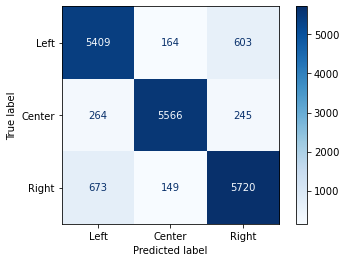

In [82]:
best_xgb = Pipeline(steps=[
    ('vect', TfidfVectorizer(preprocessor=preprocess, max_features= 2000, 
                            ngram_range= (1,2),
                            max_df = .5, min_df = 10)),
    ('clf', XGBClassifier(min_child_weight= 15,
            max_depth= 10,
            learning_rate = 0.1,
            n_estimators = 100,
            colsample_bytree = 0.3,
            reg_alpha = 10,
            reg_lambda = 10, random_state=seed, n_jobs = 8))])
best_xgb.fit(X_train["Content"], y_train)
evaluate(best_xgb, X_train["Content"], y_train, X_val["Content"], y_val)

In [83]:
idx = 12323
class_names=["Left", "Center", "Right"]
explainer = LimeTextExplainer(class_names=class_names)
exp = explainer.explain_instance(str(X_val["Content"][idx]), best_xgb.predict_proba, num_features=5, top_labels=3)
print(f'Document id: {idx}')
print(f'Predicted bias : {class_names[best_xgb.predict(list(X_val["Content"][idx])).reshape(1,-1)[0,0]]}')
print(f'True Bias: {class_names[y_val[idx]]}')
print(f'Subjectivity Score: {TextBlob(X_val["Content"][idx]).subjectivity}')
print(f'Subjectivity Score: {TextBlob(X_val["Content"][idx]).polarity}')
exp.show_in_notebook(text=X_val["Content"][idx], labels=(0,1,2))

Document id: 12323
Predicted bias : Center
True Bias: Left
Subjectivity Score: 0.5225198666747962
Subjectivity Score: 0.022757860293071547


The XGBoost Ensemble accuracy on the validation data was 88.8%. The model had a more difficult time deciding to determine left vs right bias more than right or left vs centered bias. Looking at the LIME explainer the model sees "campus", "past", and "Canada" as influencing the model the most. This is the same article but runs through a different model.

### Neural Network

In [41]:
#finds the length of the longest article
max_length = max([len(s.split()) for s in X_train["Content"]])
max_length

4450

In [42]:
#tokenizes and vectoizes text 
tokenizer = keras.preprocessing.text.Tokenizer()

tokenizer.fit_on_texts(X_train["Content"])

X_train_token = tokenizer.texts_to_sequences(X_train["Content"])
X_val_token = tokenizer.texts_to_sequences(X_val["Content"])

In [43]:
#neeed for dimensions in the neural network
vocab_size = len(tokenizer.word_index) + 1
print(vocab_size)

283818


In [44]:
#pads the documents to make sure they are all the same length
X_train_processed = keras.preprocessing.sequence.pad_sequences(
    X_train_token, maxlen=max_length, padding='post')
X_val_processed = keras.preprocessing.sequence.pad_sequences(
    X_val_token, maxlen=max_length, padding='post')

In [52]:
#one-hot encode target column
y_train2 = to_categorical(y_train)
y_val2 = to_categorical(y_val)

#vcheck that target column has been converted
y_val2[0:10]

array([[1., 0., 0.],
       [0., 1., 0.],
       [1., 0., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 0., 1.]], dtype=float32)

I will use the GloVE pretrained embedder for this network. The GloVE file to large for Git Hub, can be found here: https://nlp.stanford.edu/projects/glove/

In [54]:
#sets up the embedding dictionary
embedding_dim = 50
embedding_matrix = create_embedding_matrix('data/glove.6B.50d.txt',
                                           tokenizer.word_index, 
                                           embedding_dim)

In [58]:
model = keras.models.Sequential(name="tuned")
#Sets the first layer with the embedding dictionary
model.add(layers.Embedding(vocab_size, embedding_dim, 
                           weights=[embedding_matrix], 
                           input_length=max_length, 
                           trainable=False))
#dropout half of the nodes randomly
model.add(Dropout(0.5))
#a simple dense layer
model.add(layers.Dense(15, activation='relu'))
# flattening these layers down before connecting to dense layer
model.add(layers.Flatten()) 
#final output layer. using softmax because it is a multiclass problem
model.add(layers.Dense(3, activation='softmax'))
#compile the network
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "tuned"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 4450, 50)          14190900  
_________________________________________________________________
dropout (Dropout)            (None, 4450, 50)          0         
_________________________________________________________________
dense (Dense)                (None, 4450, 15)          765       
_________________________________________________________________
flatten (Flatten)            (None, 66750)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 200253    
Total params: 14,391,918
Trainable params: 201,018
Non-trainable params: 14,190,900
_________________________________________________________________


In [59]:
#fit the model
history = model.fit(X_train_processed, y_train2,
                    epochs=15,
                    batch_size=1000,
                    validation_data=(X_val_processed, y_val2))

Epoch 1/15
57/57 [==============================] - 167s 3s/step - loss: 1.2279 - accuracy: 0.4864 - val_loss: 1.0135 - val_accuracy: 0.4941
Epoch 2/15
57/57 [==============================] - 159s 3s/step - loss: 0.8105 - accuracy: 0.6350 - val_loss: 1.0480 - val_accuracy: 0.5479
Epoch 3/15
57/57 [==============================] - 173s 3s/step - loss: 0.7048 - accuracy: 0.7014 - val_loss: 1.1930 - val_accuracy: 0.5423
Epoch 4/15
57/57 [==============================] - 174s 3s/step - loss: 0.6212 - accuracy: 0.7480 - val_loss: 1.0731 - val_accuracy: 0.5936
Epoch 5/15
57/57 [==============================] - 173s 3s/step - loss: 0.5563 - accuracy: 0.7801 - val_loss: 1.1366 - val_accuracy: 0.6017
Epoch 6/15
57/57 [==============================] - 171s 3s/step - loss: 0.5150 - accuracy: 0.7975 - val_loss: 1.0010 - val_accuracy: 0.6525
Epoch 7/15
57/57 [==============================] - 173s 3s/step - loss: 0.4795 - accuracy: 0.8117 - val_loss: 0.9204 - val_accuracy: 0.6625
Epoch 8/15
57

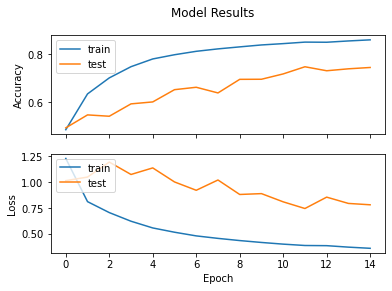

In [60]:
#display accuracy and loss scores
visualize_training_results(history)

The neural network is greatly overfit to the training data. Neural Networks may not be the best choice for this compared to other models. The other nueral networks I worked with did not perform well either.

## Final Model/Evaluation

Accuracy Score:
Train - 0.9201021670591052
Test - 0.8897402130970908
  
Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.87      0.86      2630
           1       0.95      0.92      0.94      2722
           2       0.88      0.87      0.88      3001

    accuracy                           0.89      8353
   macro avg       0.89      0.89      0.89      8353
weighted avg       0.89      0.89      0.89      8353

Confusion matrix for test data


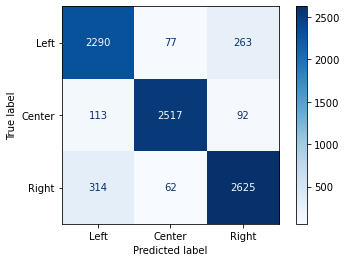

In [15]:
best_xgb = Pipeline(steps=[
    ('vect', TfidfVectorizer(preprocessor=preprocess, max_features= 2000, 
                            ngram_range= (1,2),
                            max_df = .5, min_df = 10)),
    ('clf', XGBClassifier(min_child_weight= 20,
            max_depth= 10,
            learning_rate = 0.1,
            n_estimators = 100,
            colsample_bytree = 0.3,
            reg_alpha = 10,
            reg_lambda = 10, random_state=seed, n_jobs = 8))])
best_xgb.fit(X_hold["Content"], y_hold)
evaluate(best_xgb, X_hold["Content"], y_hold, X_test["Content"], y_test)

In [16]:
# random.randint(0,X_test.shape[0])
idx = 2463
class_names=["Left", "Center", "Right"]
explainer = LimeTextExplainer(class_names=class_names)
exp = explainer.explain_instance(str(X_test["Content"][idx]), best_xgb.predict_proba, num_features=5, top_labels=3)
print(f'Document id: {idx}')
print(f'Predicted bias : {class_names[best_xgb.predict(list(X_test["Content"][idx])).reshape(1,-1)[0,0]]}')
print(f'True Bias: {class_names[y_test[idx]]}')
print(f'Subjectivity Score: {TextBlob(X_test["Content"][idx]).subjectivity}')
print(f'Polarity Score: {TextBlob(X_test["Content"][idx]).polarity}')
exp.show_in_notebook(text=X_test["Content"][idx], labels=(0,1, 2), predict_proba = False)

Document id: 2463
Predicted bias : Center
True Bias: Left
Subjectivity Score: 0.4772554435614138
Polarity Score: 0.01017752148349163


The XGBoost ensemble performed well on the hold-out set. The model achieved an accuracy of 88.9%. While it is slightly overfitting, more tunning hyperparameters will help the overall performance of the model. The final model has the same trouble distinguishing between the right to the left compared to the left or right to the center. This would be interesting to dive into deeper. The LIME Explainer shows the most important words are "Donald" "President", and "missile" are some of the top words being used to predict bias.

## Conclusion

I set out to design a model to accurately predict the bias of a news article based on the words. I also wanted to show what words the models used to make decisions to prove the trustworthiness of the model. I decided to add the polarity and subjectivity score to better describe the articles. While this algorithm needs some more work. I believe these features help advance All Sides goal of bringing more transparency into media.

I don't want to tell people what to think. I want to help people think about how we take in these hidden biases. A  <a href="https://news.stanford.edu/2019/08/22/the-power-of-language-how-words-shape-people-culture/">Stanford article</a>  states "Studying how people use language – what words and phrases they unconsciously choose and combine – can help us better understand ourselves and why we behave the way we do." And that has been the point of this project. How can we understand what words we read express some bias, and what is that bias?  I have built this model and explainer to bring transparency to what people are reading, and let them determine how they feel about what they read in the news.

Going forward, I would like to work with the model more to improve its power and capabilities by exploring a more robust dataset with more news sources and working with language transformers like BERT and GPT3. I would like to Investigate topic analysis of the corpus to see what words are on a spectrum along with the bias. And finally, I would like to create an app or browser extension for people to use no matter what site they visit. And while this is all getting worked on. All sides can beta test this with the blind rating groups and editors.